In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import scoreatpercentile
import os
from utils import *

sns.set_theme(style="darkgrid")
PATH = os.getcwd()

In [2]:
## Stocks classification (by capitalization)
mrktcap = pd.read_csv(os.path.join(PATH, 'dataSent12_21Good','CompaniesrankedMarketCap.csv'))
mrktcap = mrktcap[mrktcap.country == 'United States'] #Filter to US companies

#Add capitalization size column: small cap: 300*e6 to 2*e9;  mid cap 2e9 to 10e9; big > 10e9 
mrktcap['capsize'] = np.where(
    mrktcap['marketcap'].between(300000000, 2000000000), 'small', np.where(
    mrktcap['marketcap'].between(2000000001, 10000000000), 'mid', np.where(
    mrktcap['marketcap'] > 10000000000, 'big' , ''))) 

mrktcap.head()

,Rank,Name,Symbol,marketcap,price (USD),country,capsize
0,1,Apple,AAPL,2703284502528,163.76,United States,big
1,2,Microsoft,MSFT,2478232567808,329.49,United States,big
2,3,Alphabet (Google),GOOG,1876099203072,2875.53,United States,big
4,5,Amazon,AMZN,1743250259968,3437.36,United States,big
5,6,Tesla,TSLA,1099665113088,1084.60,United States,big


In [3]:
#Import sentiment indicator RCV for Big-caps
big_RCV = pd.read_csv(os.path.join(PATH, 'Tables','d_big_RCV.csv'))
big_RCV['date'] = pd.to_datetime(big_RCV['date']).dt.date
big_RCV.set_index('date', inplace=True)

#Percentage of nans per column (company):
big_nan_RCV = 100*big_RCV.isna().sum(axis=0)/big_RCV.shape[0]

print('big_nan_RCV Series:')
big_nan_RCV

big_nan_RCV Series:


AAL     31.933702
AAPL     3.701657
ABBV    43.867403
ABC     11.988950
ABT     30.110497
          ...    
VZ      17.845304
WFC      8.867403
WMT     14.088398
WY      41.408840
XOM     20.939227
Length: 108, dtype: float64

In [4]:
#Let's see if we have any gap in the data timespan (2012-01-02 --> 2021-12-01)
dates = pd.Series(big_RCV.index)
deltas = dates.diff()[1:] #Diff from row to row (drop 1st row since it's undefined)
gaps = deltas[deltas > dt.timedelta(days=1)]
# Print results
print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')
for i, g in gaps.iteritems():
    gap_start = dates[i - 1]
    print(f'Start: {dt.datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')

2 gaps with average gap duration: 2 days 00:00:00
Start: 2019-03-16 | Duration: 2 days, 0:00:00
Start: 2021-10-31 | Duration: 2 days, 0:00:00


In [ ]:
#Same procedure for mid and small-cap

#Mid companies
mid_RCV = pd.read_csv(os.path.join(PATH, 'Tables','d_mid_RCV.csv'))
mid_RCV['date'] = pd.to_datetime(mid_RCV['date']).dt.date
mid_RCV.set_index('date', inplace=True)
#Percentage of nans per column (company):
mid_nan_RCV = 100*mid_RCV.isna().sum(axis=0)/mid_RCV.shape[0]

#Small companies
small_RCV = pd.read_csv(os.path.join(PATH, 'Tables','d_small_RCV.csv'))
small_RCV['date'] = pd.to_datetime(small_RCV['date']).dt.date
small_RCV.set_index('date', inplace=True)
#Percentage of nans per column (company):
small_nan_RCV = 100*small_RCV.isna().sum(axis=0)/small_RCV.shape[0]


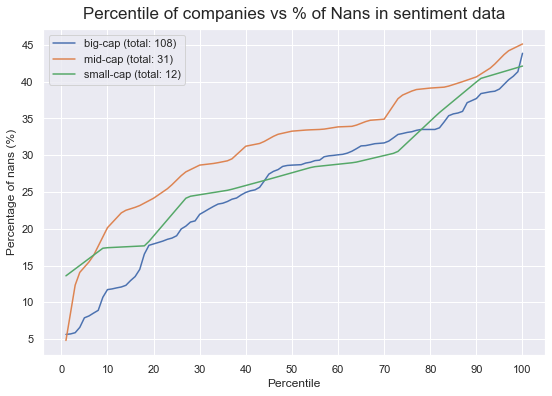

In [5]:
#Let's plot the Percentile of companies vs % of Nans in the sentiment data
a=list(range(1,101))
b = [scoreatpercentile(big_nan_RCV,i) for i in a]
m = [scoreatpercentile(mid_nan_RCV,i) for i in a]
s = [scoreatpercentile(small_nan_RCV,i) for i in a]
df = pd.DataFrame({'percentile': a, 'big % nulls': b, 'mid % nulls': m, 'small % nulls': s}, columns=['percentile', 'big % nulls', 'mid % nulls', 'small % nulls'])

fig, ax = plt.subplots(figsize = (9,6))
sns.lineplot(data=df, x="percentile", y="big % nulls", ax=ax, legend='brief', label='big-cap (total: 108)')
sns.lineplot(data=df, x="percentile", y='mid % nulls', ax=ax, legend='brief', label='mid-cap (total: 31)')
sns.lineplot(data=df, x="percentile", y='small % nulls', ax=ax, legend='brief', label='small-cap (total: 12)')
ax.set_title("Percentile of companies vs % of Nans in sentiment data", size = 17, pad = 10)
ax.set_ylabel("Percentage of nans (%)")
ax.set_xlabel("Percentile")
ax.set_xticks(range(0,101,10))
plt.show()

In [6]:
#Let's create a DF that shows the amount of nans a company has per week
#For Big-caps
big_RCV['W_Date'] = pd.to_datetime(big_RCV.index)
big_weekly_nan = big_RCV.groupby(pd.Grouper(key='W_Date', freq='W-SUN')).agg(lambda x: x.isnull().sum()).reset_index().sort_values('W_Date')
big_weekly_nan = pd.DataFrame(big_weekly_nan.set_index('W_Date'))

#Same for mid and small
mid_RCV['W_Date'] = pd.to_datetime(mid_RCV.index)
mid_weekly_nan = mid_RCV.groupby(pd.Grouper(key='W_Date', freq='W-SUN')).agg(lambda x: x.isnull().sum()).reset_index().sort_values('W_Date')
mid_weekly_nan = pd.DataFrame(mid_weekly_nan.set_index('W_Date'))

small_RCV['W_Date'] = pd.to_datetime(small_RCV.index)
small_weekly_nan = small_RCV.groupby(pd.Grouper(key='W_Date', freq='W-SUN')).agg(lambda x: x.isnull().sum()).reset_index().sort_values('W_Date')
small_weekly_nan = pd.DataFrame(small_weekly_nan.set_index('W_Date'))

big_weekly_nan.head()

,AAL,AAPL,ABBV,ABC,ABT,ADP,AIG,AMD,AMZN,AXP,...,UAL,UNH,UPS,USB,V,VZ,WFC,WMT,WY,XOM
W_Date,,,,,,,,,,,,,,,,,,,,,
2012-01-08,2,1,7,2,2,3,3,3,2,3,...,0,3,2,1,3,2,1,2,4,0
2012-01-15,3,1,7,0,2,5,1,2,0,1,...,0,1,1,0,2,1,1,2,3,0
2012-01-22,2,1,7,0,1,4,2,3,1,1,...,0,2,2,2,3,2,1,0,4,0
2012-01-29,1,0,7,0,2,2,1,3,1,1,...,0,3,2,1,3,2,1,2,5,0
2012-02-05,3,0,7,2,2,2,2,1,0,1,...,0,1,2,1,1,0,2,1,2,0


In [7]:
#Create a Dataframe with the weekly count of companies that have x amount of nans, where x=[0,1,2,3,4,5,6,7]
#Big-caps
big_weekly_companies_by_nans = big_weekly_nan.apply(pd.value_counts, axis=1).fillna(0)
#Mid-caps
mid_weekly_companies_by_nans = mid_weekly_nan.apply(pd.value_counts, axis=1).fillna(0)
#Small-caps
small_weekly_companies_by_nans = small_weekly_nan.apply(pd.value_counts, axis=1).fillna(0)

big_weekly_companies_by_nans.head()

,0,1,2,3,4,5,6,7
W_Date,,,,,,,,
2012-01-08,9.0,24.0,30.0,23.0,10.0,6.0,3.0,3.0
2012-01-15,19.0,34.0,39.0,7.0,5.0,3.0,0.0,1.0
2012-01-22,22.0,30.0,30.0,16.0,8.0,1.0,0.0,1.0
2012-01-29,14.0,40.0,36.0,12.0,3.0,2.0,0.0,1.0
2012-02-05,13.0,34.0,39.0,15.0,4.0,2.0,0.0,1.0


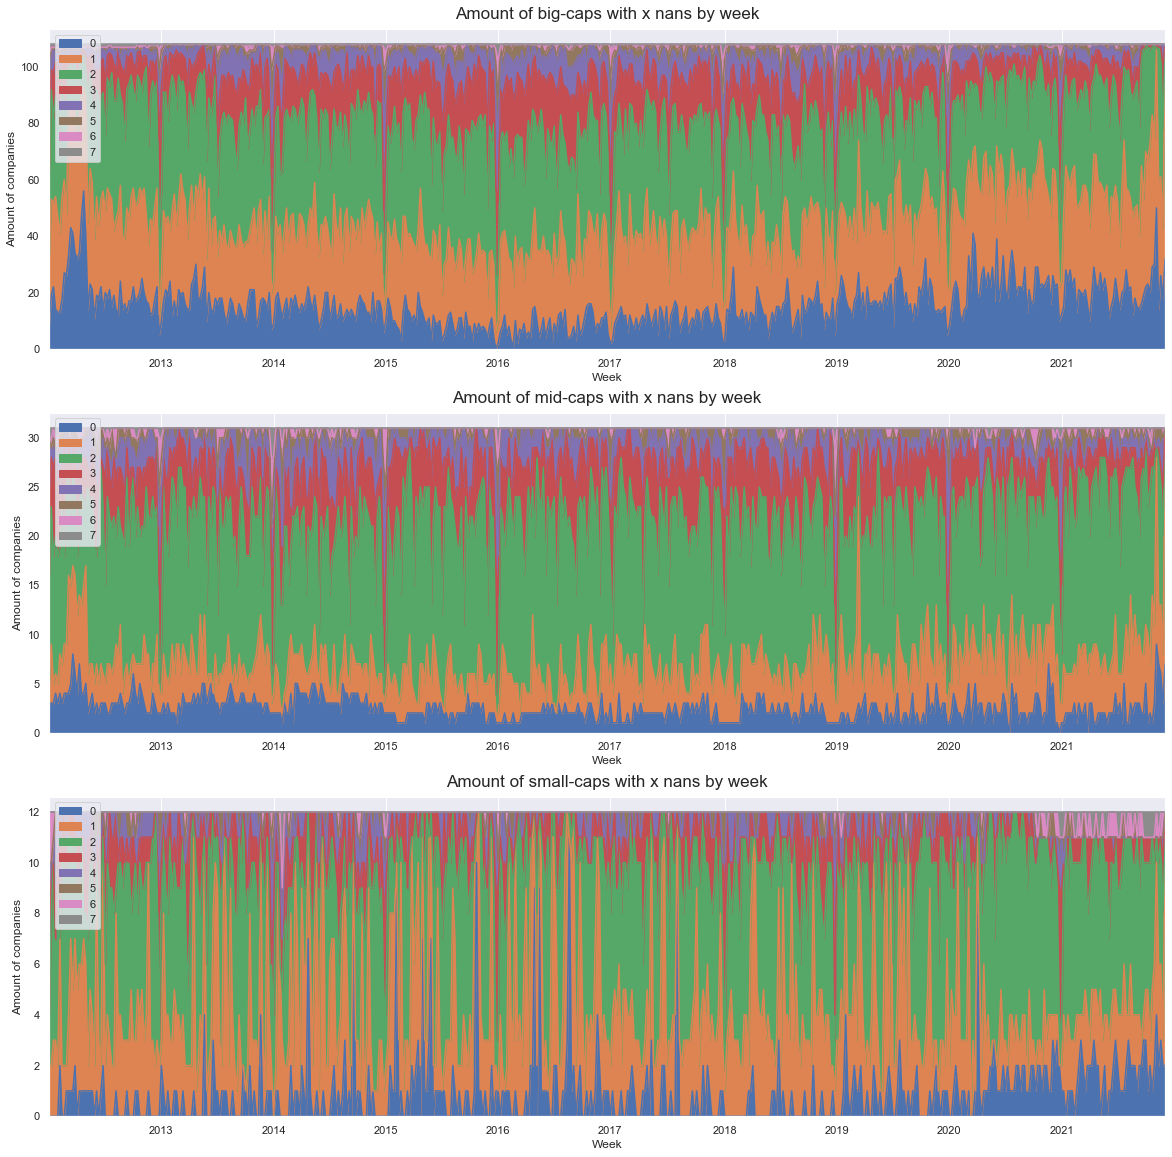

In [8]:
fig2 = plt.figure(figsize=(20,20))
ax = fig2.add_subplot(3,1,1)
big_weekly_companies_by_nans.plot(kind='area', ax = ax)
ax.set_title("Weekly number of big-caps by number of nans", size = 17, pad = 10)
ax.set_ylabel("Number of companies")
ax.set_xlabel("Week")
ax.legend(loc='upper left')

ax2 = fig2.add_subplot(3,1,2)
mid_weekly_companies_by_nans.plot(kind='area', ax = ax2)
ax2.set_title("Weekly number of mid-caps by number of nans", size = 17, pad = 10)
ax2.set_ylabel("Number of companies")
ax2.set_xlabel("Week")
ax2.legend(loc='upper left')

ax3 = fig2.add_subplot(3,1,3)
small_weekly_companies_by_nans.plot(kind='area', ax = ax3)
ax3.set_title("Weekly number of small-caps by number of nans", size = 17, pad = 10)
ax3.set_ylabel("Number of companies")
ax3.set_xlabel("Week")
ax3.legend(loc='upper left')
plt.show()

In [9]:
print("Number of Big sized companies: ",len(big_RCV.columns))
print("Number of Medium sized companies: ",len(mid_RCV.columns))
print("Number of Small sized companies: ", len(small_RCV.columns))

Number of Big sized companies:  109
Number of Medium sized companies:  32
Number of Small sized companies:  13


We check viable stocks with less than 20% missing values. We note that there aren't many (28) from the original 108. Next we want to know if we remove some consecutive early years, we get a lower proportion of NaN's.

In [10]:
get_viable_stocks(big_RCV, 0.2).shape

(29,)

By removing the first 3 years we only improve by one stocks, which means that the missing values are relatively uniformlly distributed.

In [117]:
remove_years(big_RCV, 3, 0.2).shape

(30,)

We could be more flexible with our tolerance for NaNs and cosider stocks with at most 25% which brings us up to 44.

In [118]:
remove_years(big_RCV, 0,0.25).shape

(44,)

We also want to check if at any given year there were more than 20% or 25% NaN's so we could only select the stocks that make sense. There are only 24 of these. This means that we need to either relax our missing data threshold or only work on fullish stocks. Notice that this is for big companies, smaller companies have less information.

In [119]:
viable_years(big_RCV, 0.25).shape

(24,)

In [120]:
print("Viable stocks for Medium sized companies: ", len(get_viable_stocks(mid_sent_tables['mid_RCV'], 0.2)))
print("Viable stocks for Small sized companies: ", len(get_viable_stocks(small_sent_tables['small_RCV'], 0.2)))

Viable stocks for Medium sized companies:  3
Viable stocks for Small sized companies:  3


In [121]:
two = get_weekly_stocks(big_RCV, 2) > 80
two.mean()*100


63.26923076923077

Red dotted line is at 80 viable stocks. The volume of viable stocks represents the count (ie how many weeks we have x amount of viable stocks). 

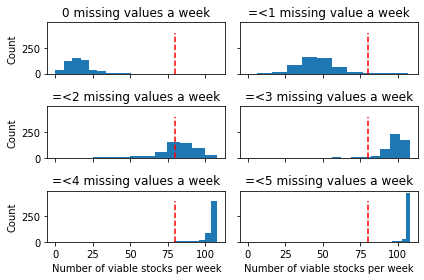

In [122]:
plothist(big_RCV, 80)

In [123]:
percent_above(big_RCV, 80)

If we allow 0 or less NaN's we get 0.0 percent of weeks with more than 80 viable stocks
If we allow 1 or less NaN's we get 2.1153846153846154 percent of weeks with more than 80 viable stocks
If we allow 2 or less NaN's we get 63.26923076923077 percent of weeks with more than 80 viable stocks
If we allow 3 or less NaN's we get 95.76923076923077 percent of weeks with more than 80 viable stocks
If we allow 4 or less NaN's we get 99.42307692307692 percent of weeks with more than 80 viable stocks
If we allow 5 or less NaN's we get 100.0 percent of weeks with more than 80 viable stocks
